# Timelag Analysis: Heating Cases
In this notebook, we'll compare the timelags across our four different heating cases:
* cooling
* high-frequency nanoflares
* intermediate-frequency nanoflares
* low-frequency nanoflares

In [117]:
import os
import sys
from imp import reload

import numpy as np
from scipy.interpolate import splev,interp1d
import scipy.stats
import h5py
import dask
import dask.array
import dask.distributed
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map,GenericMap
from sunpy.util.metadata import MetaDict
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import SqrtStretch,ImageNormalize,AsinhStretch,LogStretch

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels

sys.path.append('../scripts/')
#from timelags import AIATimeLags,AIATimeLagsObserved
import timelags
reload(timelags)

%matplotlib inline

In [112]:
client = dask.distributed.Client()
client

<Client: scheduler='tcp://127.0.0.1:46433' processes=64 cores=64>

In [111]:
client.close()

In [ ]:
def idl_correlate(s_1, s_2, lags):
    """
    Numpy implementation of c_correlate.pro IDL routine
    """
    # ensure signals are of equal length
    assert s_1.shape == s_2.shape
    n_s = s_1.shape[0]
    # center both signals
    s_1_center = s_1 - s_1.mean()
    s_2_center = s_2 - s_2.mean()
    # allocate space for correlation
    correlation = np.zeros(lags.shape)
    # iterate over lags
    for i,l in enumerate(lags):
        if l >= 0:
            tmp = s_1_center[:(n_s - l)] * s_2_center[l:]
        else:
            tmp = s_1_center[-l:] * s_2_center[:(n_s + l)]
        correlation[i] = tmp.sum()
    # Divide by standard deviation of both
    correlation /= np.sqrt((s_1_center**2).sum() * (s_2_center**2).sum())
    
    return correlation

## Load Data

In [3]:
aia_cooling = InstrumentSDOAIA([0,10000]*u.s)
aia_cooling.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/nei/SDO_AIA_counts.h5'
aia_cooling_outofphase = InstrumentSDOAIA([0,10000]*u.s)
aia_cooling_outofphase.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase/nei/SDO_AIA_counts.h5'
aia_high = InstrumentSDOAIA([5000,25000]*u.s)
aia_high.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/nei/SDO_AIA_counts.h5'
aia_intermediate = InstrumentSDOAIA([5000,25000]*u.s)
aia_intermediate.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/SDO_AIA_counts.h5'
aia_low = InstrumentSDOAIA([5000,25000]*u.s)
aia_low.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/SDO_AIA_counts.h5'

Now load in all the data for our four heating cases. We'll focus on the NEI cases. (Or if we've already built the HDF5 file, just pass in the filename)

In [4]:
tl_cooling = AIATimeLags(aia_cooling, 'intensity_maps_cooling.h5',
                         #fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/nei/'
                        )

In [5]:
tl_cooling_outofphase = AIATimeLags(aia_cooling_outofphase, 'intensity_maps_cooling_outofphase.h5',
                                    #fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase/nei/'
                                   )

In [6]:
tl_high = AIATimeLags(aia_high, 'intensity_maps_high_frequency.h5',
                      #fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/nei/'
                     )

In [7]:
tl_intermediate = AIATimeLags(aia_intermediate, 'intensity_maps_intermediate_frequency.h5',
                              #fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/'
                             )

In [8]:
tl_low = AIATimeLags(aia_low, 'intensity_maps_low_frequency.h5',
                     #fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/'
                    )

## Peek AIA Maps
Take a quick look at the intensity for a given snapshot in time for all channels for four cases.

In [ ]:
plot_aia_channels(aia_cooling,500*u.s,'/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/nei/',
                  norm=ImageNormalize(vmin=0,vmax=5e2,stretch=SqrtStretch()))

In [ ]:
plot_aia_channels(aia_cooling_outofphase, 7500*u.s, '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase/nei/',
                  norm=ImageNormalize(vmin=0,vmax=5e2,stretch=SqrtStretch())
                 )

In [ ]:
plot_aia_channels(aia_high,15000*u.s,'/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/nei/',
                  norm=ImageNormalize(vmin=0,vmax=5e2,stretch=SqrtStretch())
                 )

In [ ]:
plot_aia_channels(aia_intermediate,15000*u.s,'/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/',
                  norm=ImageNormalize(vmin=0,vmax=5e2,stretch=SqrtStretch()))

In [ ]:
plot_aia_channels(aia_low,15000*u.s,'/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/',
                  norm=ImageNormalize(vmin=0,vmax=5e2,stretch=SqrtStretch()))

## 1D Correlations
Take a 1D slice averaged over a few pixels for each group and compute the timelags for a few channel pairs

In [9]:
xc,yc = -325*u.arcsec, -200*u.arcsec
dx,dy = 1*u.arcsec, 1*u.arcsec
lower_left_corner = (xc-dx/2,yc-dy/2)
upper_right_corner = (xc+dx/2,yc+dy/2)
coords  = (lower_left_corner,upper_right_corner)

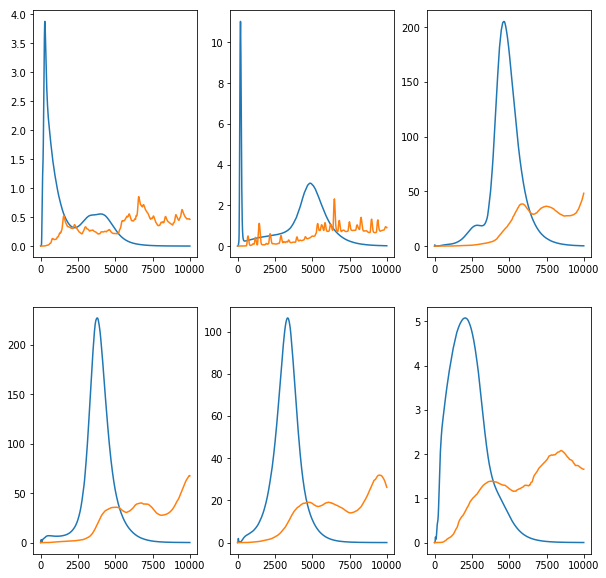

In [10]:
fig,axes = plt.subplots(2,3,figsize=(10,10))
for i,(channel,ax) in enumerate(zip(aia_cooling.channels,axes.flatten())):
    ts_cooling = tl_cooling.make_timeseries(channel['name'],lower_left_corner,upper_right_corner)
    ax.plot(aia_cooling.observing_time,ts_cooling,color='C0')
    ts_cooling = tl_cooling_outofphase.make_timeseries(channel['name'],lower_left_corner,upper_right_corner)
    ax.plot(aia_cooling_outofphase.observing_time,ts_cooling,color='C1')

Text(0,0.5,'$I$ [DN/pix/s]')

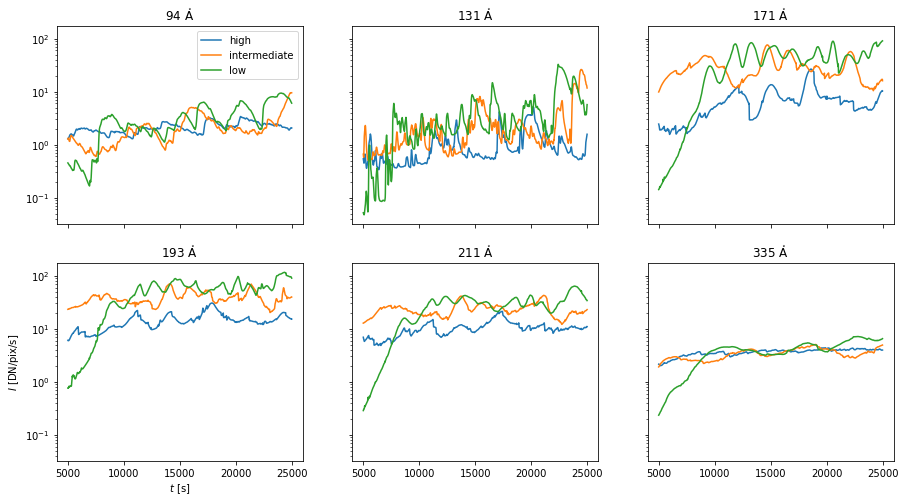

In [11]:
fig,axes = plt.subplots(2,3,figsize=(15,8),sharex=True,sharey=True)
for i,(channel,ax) in enumerate(zip(aia_cooling.channels,axes.flatten())):
    ts_high = tl_high.make_timeseries(channel['name'],*coords)
    ax.plot(aia_high.observing_time,ts_high,color=f'C0',label='high')
    ts_intermediate = tl_intermediate.make_timeseries(channel['name'],*coords)
    ax.plot(aia_intermediate.observing_time,ts_intermediate,color=f'C1',label='intermediate')
    ts_low = tl_low.make_timeseries(channel['name'],*coords)
    ax.plot(aia_low.observing_time,ts_low,color=f'C2',label='low')
    ax.set_title(f'{channel["name"]} $\mathring{{\mathrm{{A}}}}$')
    ax.set_yscale('log')
axes[0,0].legend()
axes[1,0].set_xlabel(r'$t$ [s]')
axes[1,0].set_ylabel(r'$I$ [DN/pix/s]')

In [12]:
channel_pairs = [(94,335), (94,171), (335,211), (335,171), (193,171), (171,131)]

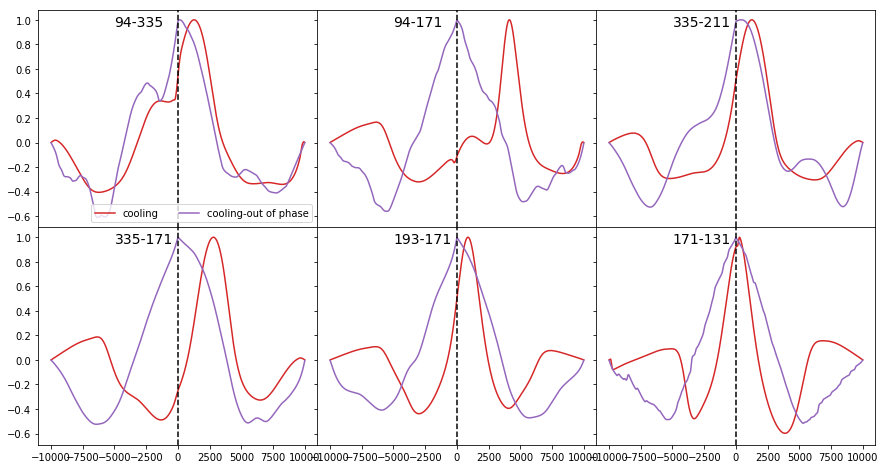

In [13]:
fig,axes = plt.subplots(2,3,figsize=(15,8),sharex=True,sharey=True)
for i,(p,ax) in enumerate(zip(channel_pairs,axes.flatten())):
    # cooling
    cc_cooling = tl_cooling.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl_cooling.timelags,cc_cooling/cc_cooling.max(),color='C3',ls='-',label='cooling')
    # cooling--out of phase
    cc_cooling = tl_cooling_outofphase.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl_cooling_outofphase.timelags,cc_cooling/cc_cooling.max(),color='C4',ls='-',label='cooling-out of phase')
    ax.axvline(x=0,ls='--',color='k')
    ax.text(-5e3,0.95,'{}-{}'.format(*p),fontsize=14)
#axes[0,0].set_xlim([-5e3,5e3])
axes[0,0].legend(loc=4,ncol=2)
plt.subplots_adjust(hspace=0,wspace=0)

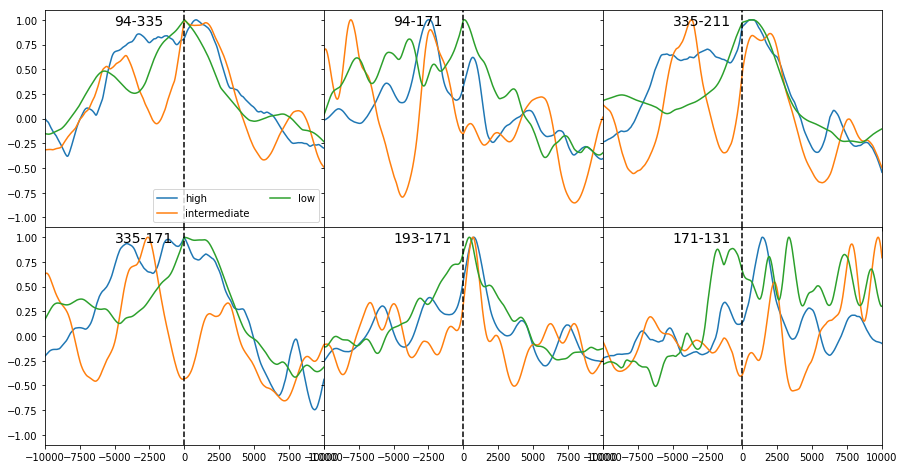

In [15]:
fig,axes = plt.subplots(2,3,figsize=(15,8),sharex=True,sharey=True)
for i,(p,ax) in enumerate(zip(channel_pairs,axes.flatten())):
    # cooling
    #cc_cooling = tl_cooling.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    #ax.plot(tl_cooling.timelags,cc_cooling/cc_cooling.max(),color='C3',ls='-',label='cooling')
    # cooling--out of phase
    #cc_cooling = tl_cooling_outofphase.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    #ax.plot(tl_cooling_outofphase.timelags,cc_cooling/cc_cooling.max(),color='C4',ls='-',label='cooling-out of phase')
    # high frequency
    cc_high = tl_high.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl_high.timelags,cc_high/cc_high.max(),color=f'C0',ls='-',label='high')
    # intermediate frequency
    cc_intermediate = tl_intermediate.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl_intermediate.timelags,cc_intermediate/cc_intermediate.max(),color=f'C1',ls='-',label='intermediate')
    # low frequency
    cc_low = tl_low.correlation_1d(f'{p[0]}', f'{p[1]}',*coords)
    ax.plot(tl_low.timelags,cc_low/cc_low.max(),color=f'C2',ls='-',label='low')
    ax.axvline(x=0,ls='--',color='k')
    ax.text(-9e3,0.95,'{}-{}'.format(*p),fontsize=14)
axes[0,0].set_xlim([-1e4,1e4])
axes[0,0].legend(loc=4,ncol=2)
axes[0,0].set_ylim([-1.1, 1.1])
plt.subplots_adjust(hspace=0,wspace=0)

## 2D Timelag Maps
Now, compute the timelag maps for several different channel pairs for all four of our different heating functions. From Viall and Klimchuk (2017), we want to look at the channel pairs,

* 94-335
* 94-171
* 335-211
* 335-171
* 193-171
* 171-131

Compute maps and histograms for each of these. Show grid of timelag maps, rows are the channel pairs, columns are the heating models. Finally, 

In [25]:
timelag_maps = {}
for p in channel_pairs:
    timelag_maps['{}-{}'.format(*p)] = {}
    timelag_maps['{}-{}'.format(*p)]['cooling'] = tl_cooling.make_timelag_map(f'{p[0]}',f'{p[1]}')
    timelag_maps['{}-{}'.format(*p)]['cooling_outofphase'] = tl_cooling_outofphase.make_timelag_map(f'{p[0]}',f'{p[1]}')
    timelag_maps['{}-{}'.format(*p)]['high_frequency'] = tl_high.make_timelag_map(f'{p[0]}',f'{p[1]}')
    timelag_maps['{}-{}'.format(*p)]['intermediate_frequency'] = tl_intermediate.make_timelag_map(f'{p[0]}',f'{p[1]}')
    timelag_maps['{}-{}'.format(*p)]['low_frequency'] = tl_low.make_timelag_map(f'{p[0]}',f'{p[1]}')

In [20]:
correlation_maps = {}
for p in channel_pairs:
    correlation_maps['{}-{}'.format(*p)] = {}
    correlation_maps['{}-{}'.format(*p)]['cooling'] = tl_cooling.make_correlation_map(f'{p[0]}',f'{p[1]}')
    correlation_maps['{}-{}'.format(*p)]['cooling_outofphase'] = tl_cooling_outofphase.make_correlation_map(f'{p[0]}',f'{p[1]}')
    correlation_maps['{}-{}'.format(*p)]['high_frequency'] = tl_high.make_correlation_map(f'{p[0]}',f'{p[1]}')
    correlation_maps['{}-{}'.format(*p)]['intermediate_frequency'] = tl_intermediate.make_correlation_map(f'{p[0]}',f'{p[1]}')
    correlation_maps['{}-{}'.format(*p)]['low_frequency'] = tl_low.make_correlation_map(f'{p[0]}',f'{p[1]}')

Now plot all the heating models and compare across channel pairs.

In [130]:
correlation_cutoff = 500.0

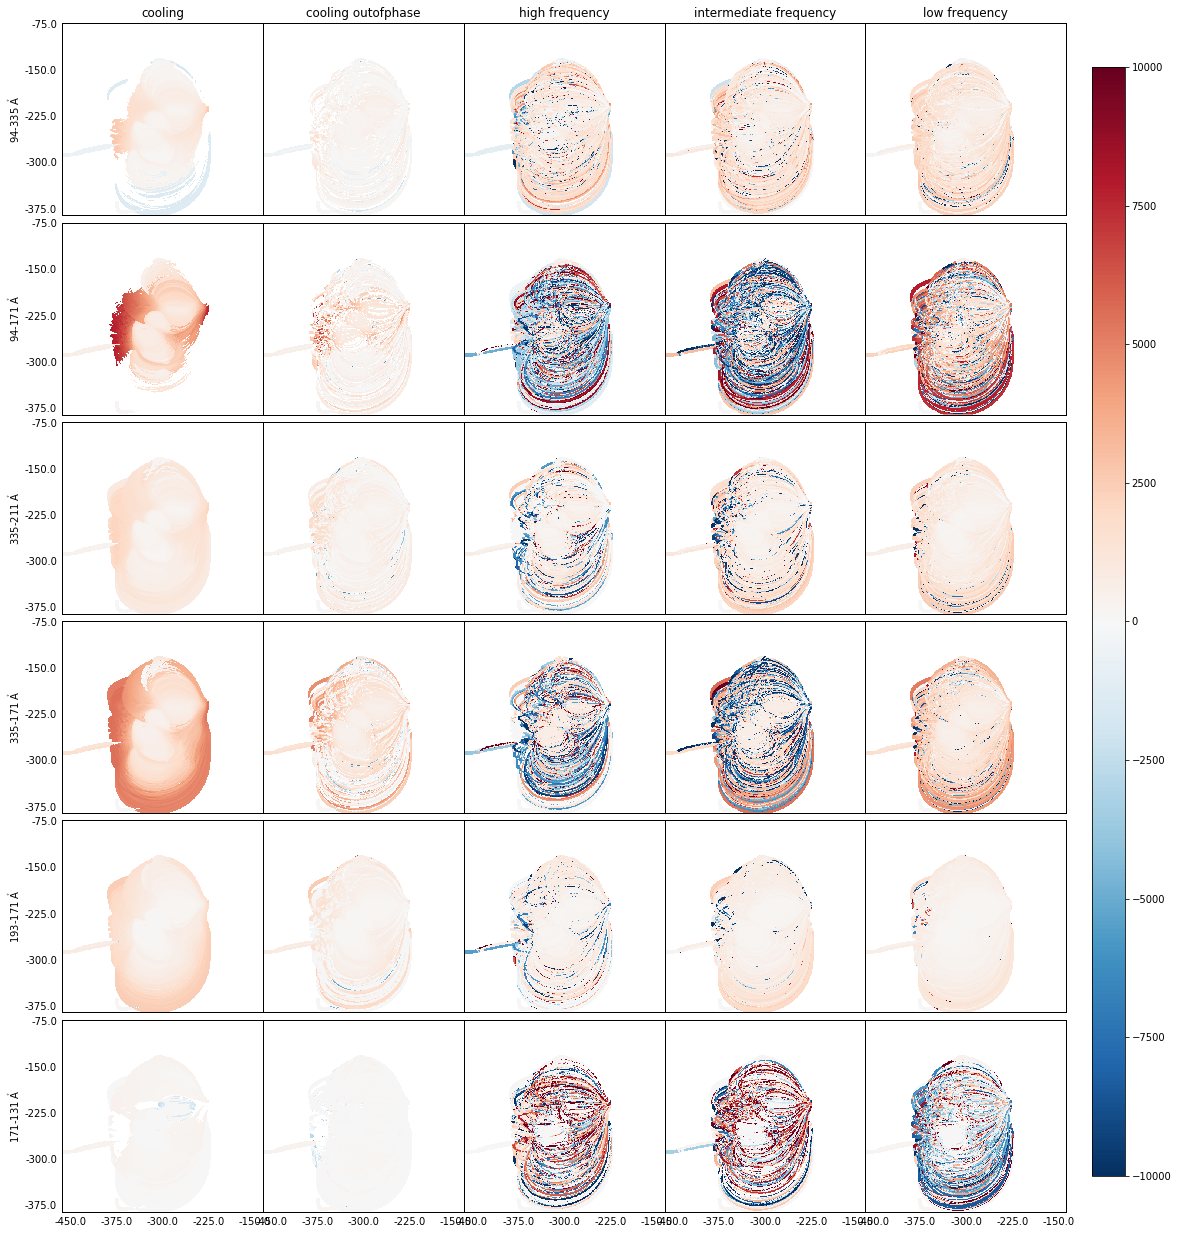

In [131]:
fig = plt.figure(figsize=(18,22))
plt.subplots_adjust(hspace=0,wspace=0)
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
# tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
for i,(c_a,c_b) in enumerate(channel_pairs):
    for j,heating in enumerate(['cooling', 'cooling_outofphase', 'high_frequency','intermediate_frequency','low_frequency']):
        tmp = Map(timelag_maps[f'{c_a}-{c_b}'][heating])
        tmp_cor = Map(correlation_maps[f'{c_a}-{c_b}'][heating])
        data = np.where((tmp_cor.data) < correlation_cutoff, np.nan, tmp.data)
        tmp = Map(data, tmp.meta)
        tmp.plot_settings.update({'cmap':'RdBu_r','vmin':-1e4,'vmax':1e4})
        ax = fig.add_subplot(len(channel_pairs),5,5*i+j+1,projection=tmp)
        im = tmp.plot(annotate=False,title=False)
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.grid(draw_grid=False)
        lat.grid(draw_grid=False)
        if j==0:
            lat.set_axislabel(f'{c_a}-{c_b} $\mathrm{{\mathring{{A}}}}$')
        if i<len(channel_pairs)-1:
            lon.set_ticklabel_visible(False)
            lon.set_ticks_visible(False)
        if j > 0:
            lat.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
        if i==0:
            ax.set_title(' '.join(heating.split('_')))
cbar = fig.colorbar(im, cax=cax)

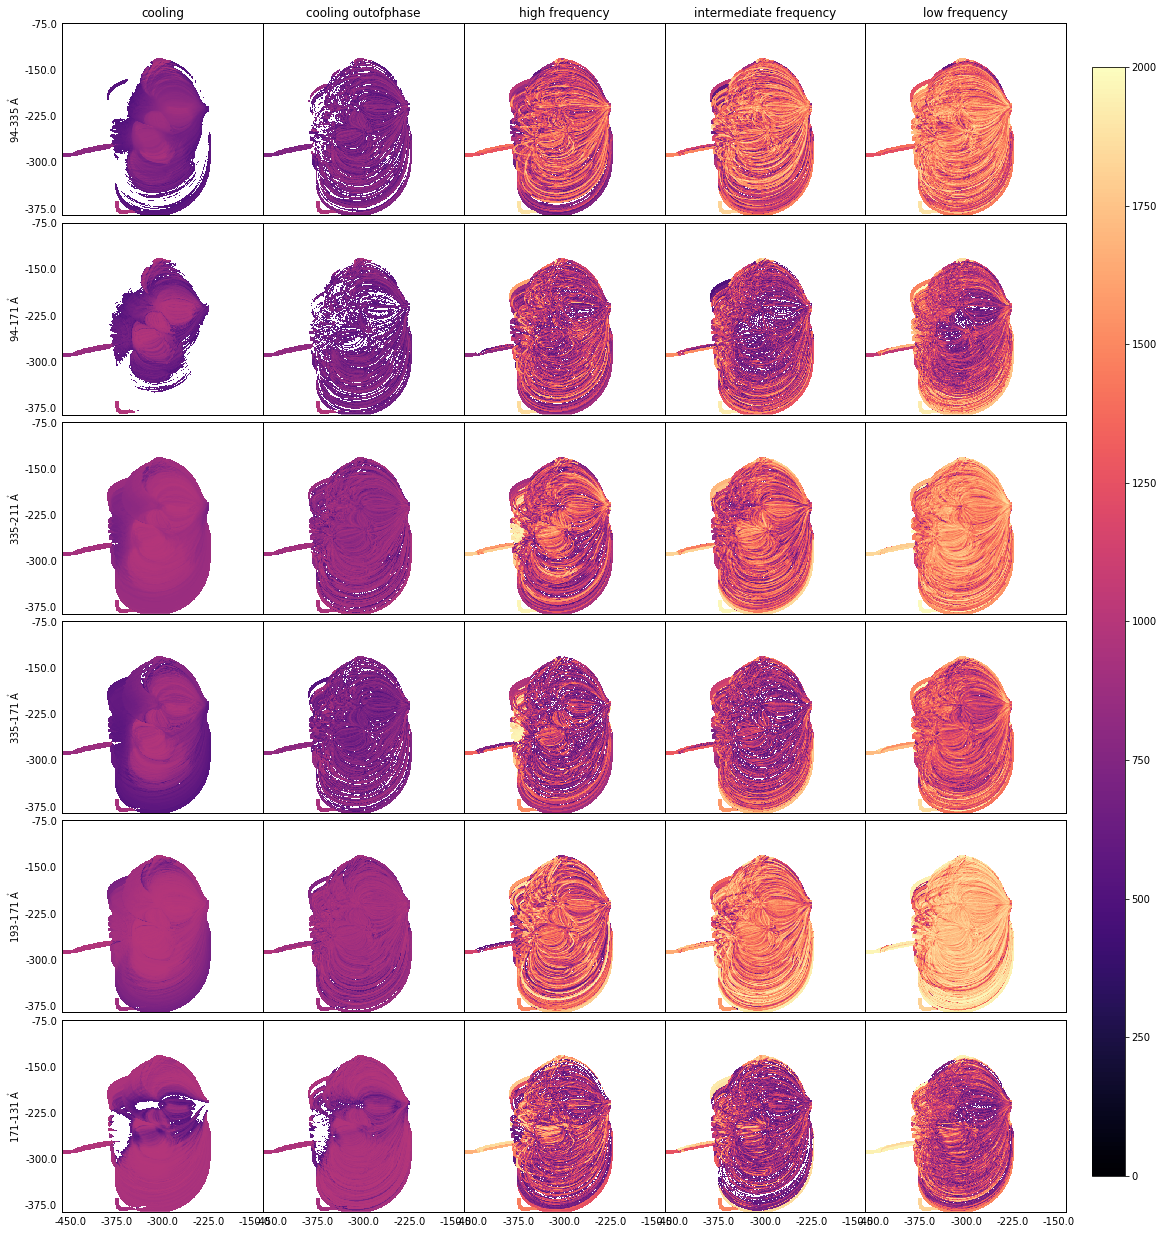

In [132]:
fig = plt.figure(figsize=(18,22))
plt.subplots_adjust(hspace=0,wspace=0)
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
#tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/correlation_map_{}_{}.fits'
# cooling
for i,(c_a,c_b) in enumerate(channel_pairs):
    for j,heating in enumerate(['cooling','cooling_outofphase','high_frequency','intermediate_frequency','low_frequency']):
        tmp = Map(correlation_maps[f'{c_a}-{c_b}'][heating])
        data = np.where(tmp.data < correlation_cutoff, np.nan, tmp.data)
        tmp = Map(data, tmp.meta)
        tmp.plot_settings.update({'cmap':'magma','vmin':0,'vmax':2e3})
        ax = fig.add_subplot(len(channel_pairs), 5, 5*i+j+1, projection=tmp)
        im = tmp.plot(annotate=False,title=False)
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.grid(draw_grid=False)
        lat.grid(draw_grid=False)
        if j==0:
            lat.set_axislabel(f'{c_a}-{c_b} $\mathrm{{\mathring{{A}}}}$')
        if i<len(channel_pairs)-1:
            lon.set_ticklabel_visible(False)
            lon.set_ticks_visible(False)
        if j > 0:
            lat.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
        if i==0:
            ax.set_title(' '.join(heating.split('_')))
cbar = fig.colorbar(im, cax=cax)

## Timelag Distributions

Finally, compare them on a histogram

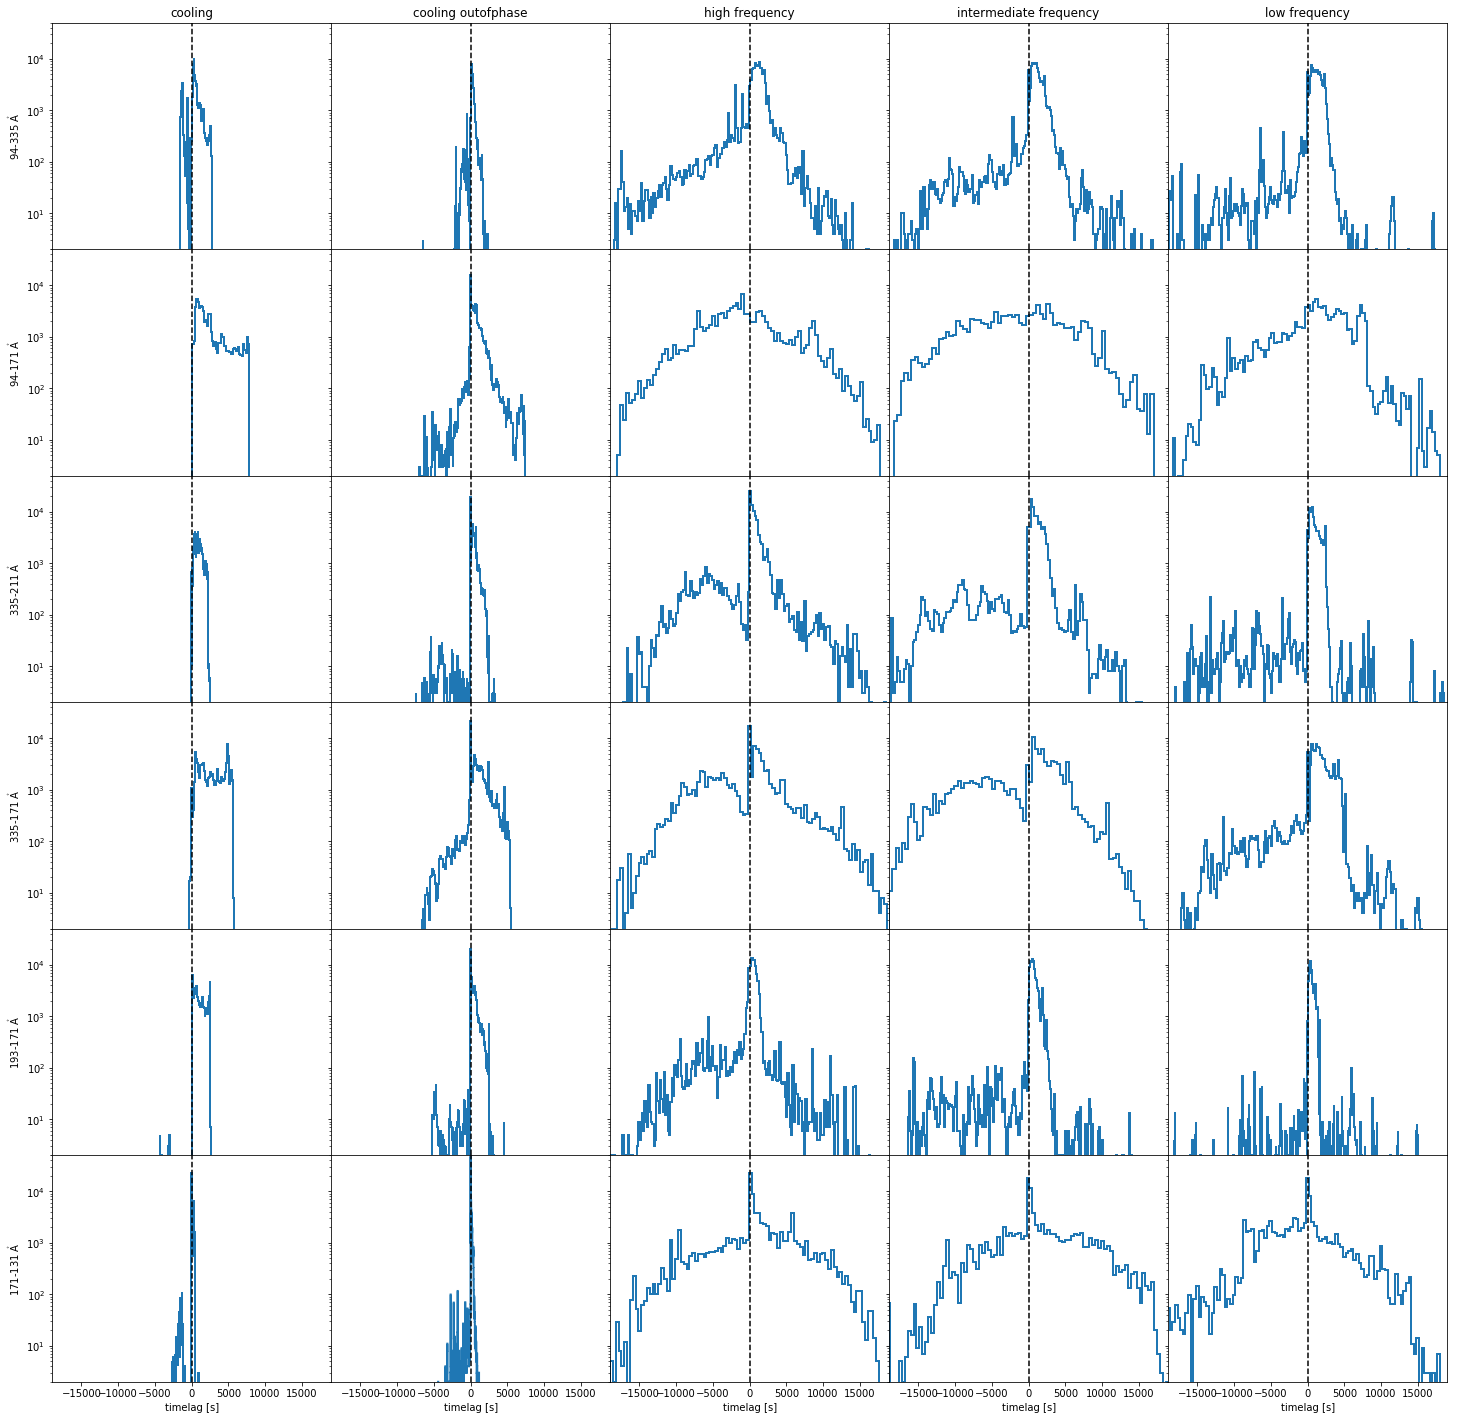

In [133]:
params = {'log':True,'bins':'scott','histtype':'step','lw':2,'normed':False,'cumulative':False}
fig,axes = plt.subplots(len(channel_pairs),5,figsize=(25,25),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
# tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
for i,p in enumerate(channel_pairs):
    for j,heating in enumerate([
                                'cooling',
                                'cooling_outofphase',
                                'high_frequency',
                                'intermediate_frequency',
                                'low_frequency'
                               ]):
        ax = axes[i,j]
        tmp = timelag_maps['{}-{}'.format(*p)][heating]
        data = tmp.data.flatten()
        tmp = correlation_maps['{}-{}'.format(*p)][heating]
        data_cor = tmp.data.flatten()
        dist = data[np.where(data_cor >= correlation_cutoff)]
        sk = scipy.stats.skew(dist)
        ax.hist(dist, **params,label=' '.join(heating.split('_'))+f', {sk:.3f}',color=f'C0',ls='-',)
        ax.axvline(x=0,ls='--',color='k')
        #ax.legend(loc=2,ncol=1)
        if j == 0:
            ax.set_ylabel(r'{}-{} $\mathrm{{\mathring{{A}}}}$'.format(*p))
        if i == 5:
            ax.set_xlabel(r'timelag [s]')
        if i == 0:
            ax.set_title(' '.join(heating.split('_')))
axes[0,0].set_xlim(-1.9e4,1.9e4);
axes[0,0].set_ylim(2,5e4);

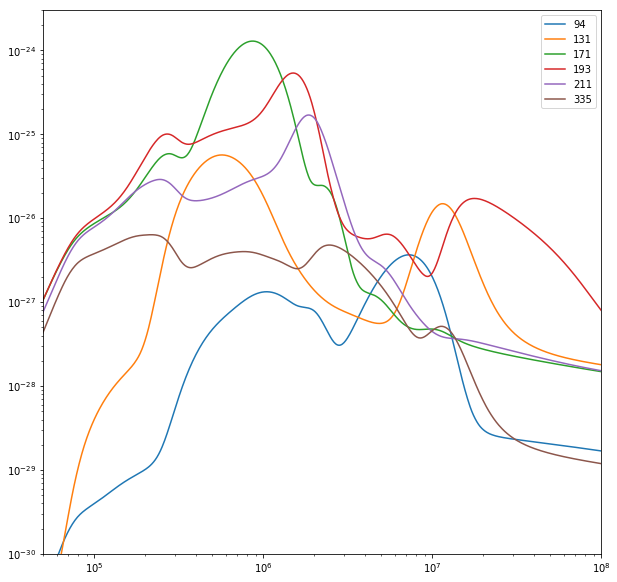

In [29]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
temperature_grid = np.logspace(4,9,1000)
for channel in aia_cooling.channels:
    resp = splev(temperature_grid, channel['temperature_response_spline'])
    ax.plot(temperature_grid,resp,label=channel['name'])
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(1e-30,3e-24)
plt.xlim(5e4,1e8)
ax.legend()

## Computing Similarity to Observed Maps
One possible way to make a selection of the "best" heating model is to compute the observed timelags for all of these channels (using the same method as here) and then compute some sort of statistical distance between the distributions of timelags. A "pixel-by-pixel" comparison does not make much sense as this would likely be thrown off by the obvious issues with the field extrapolation and would not be a great test of the heating model itself.

In [121]:
tl_observed = timelags.AIATimeLagsObserved('observations/intensity_maps_observed.h5',
                                           #fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/'
                                          )

In [122]:
observed_timelag_maps, observed_correlation_maps = {}, {}
for p in channel_pairs:
    observed_timelag_maps['{}-{}'.format(*p)] = tl_observed.make_timelag_map(f'{p[0]}',f'{p[1]}')
    observed_correlation_maps['{}-{}'.format(*p)] = tl_observed.make_correlation_map(f'{p[0]}',f'{p[1]}')

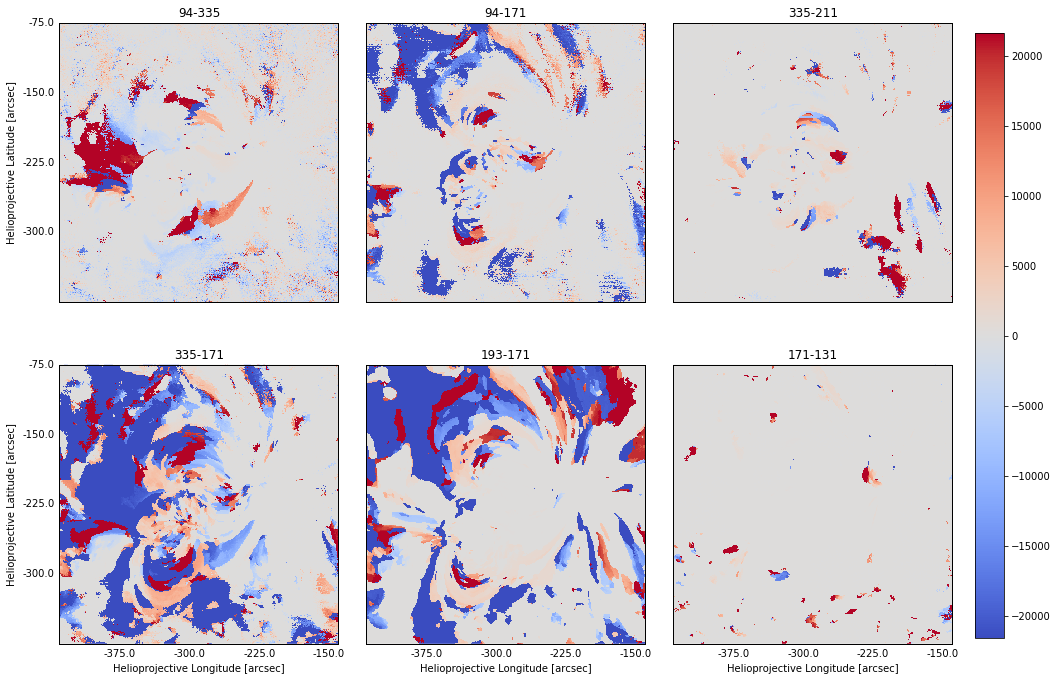

In [123]:
fig = plt.figure(figsize=(16,12))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = observed_timelag_maps['{}-{}'.format(*cp)]
    ax = fig.add_subplot(2, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=-(6*u.hour).to(u.s).value,
                vmax=(6*u.hour).to(u.s).value,
                cmap='coolwarm')
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 2:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

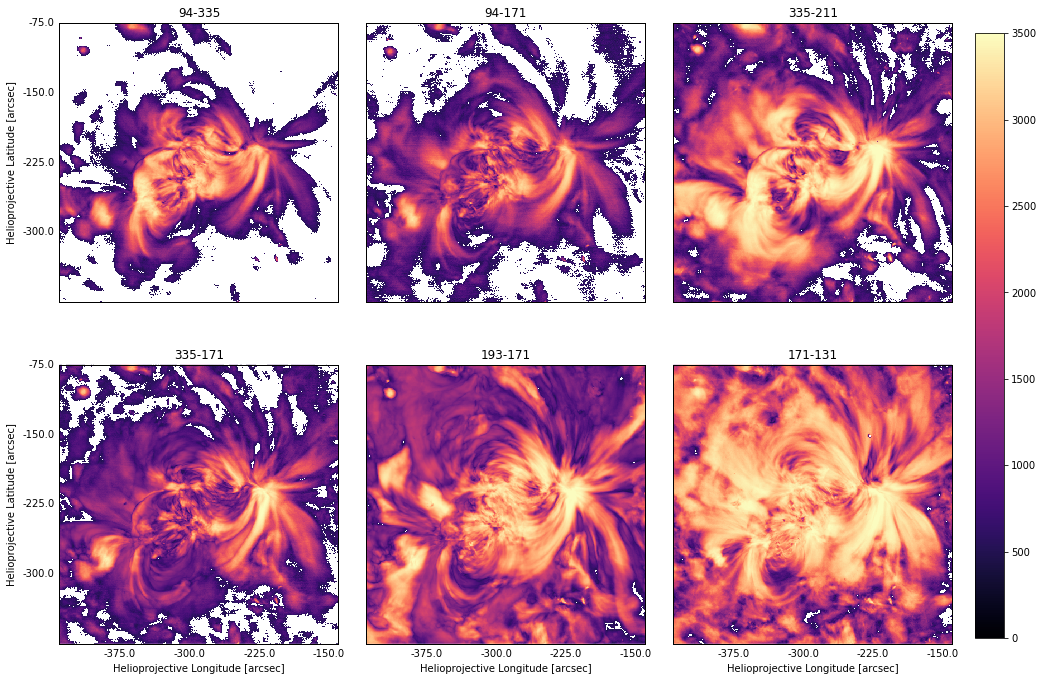

In [134]:
fig = plt.figure(figsize=(16,12))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = observed_correlation_maps['{}-{}'.format(*cp)]
    data = m.data #/ m.data.max()
    data = np.where(data < correlation_cutoff, np.nan, data)
    m = Map(data, m.meta)
    ax = fig.add_subplot(2, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=0, vmax=3.5e3, cmap='magma')
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 2:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

In [195]:
def chi_squared_mod(data_1, data_2, bins, normed=False):
    """
    Modified chi-squared test (see Eq. 14.3.3 of Numerical Recipes)
    """
    ds_1,_ = np.histogram(data_1, bins=bins, normed=normed)
    ds_2,_ = np.histogram(data_2, bins=bins, normed=normed)
    w_1 = data_1.shape[0]
    w_2 = data_2.shape[0]
    numerator = (np.sqrt(w_1/w_2) * ds_2 - np.sqrt(w_2/w_1) * ds_1)**2
    denominator = ds_1 + ds_2
    # Exclude the cases of empty bins in both sets
    tot = numerator[denominator != 0] / denominator[denominator != 0]
    return tot.sum()

In [196]:
bins = np.linspace(-(6*u.hour).to(u.s).value, (6*u.hour).to(u.s).value, 100)

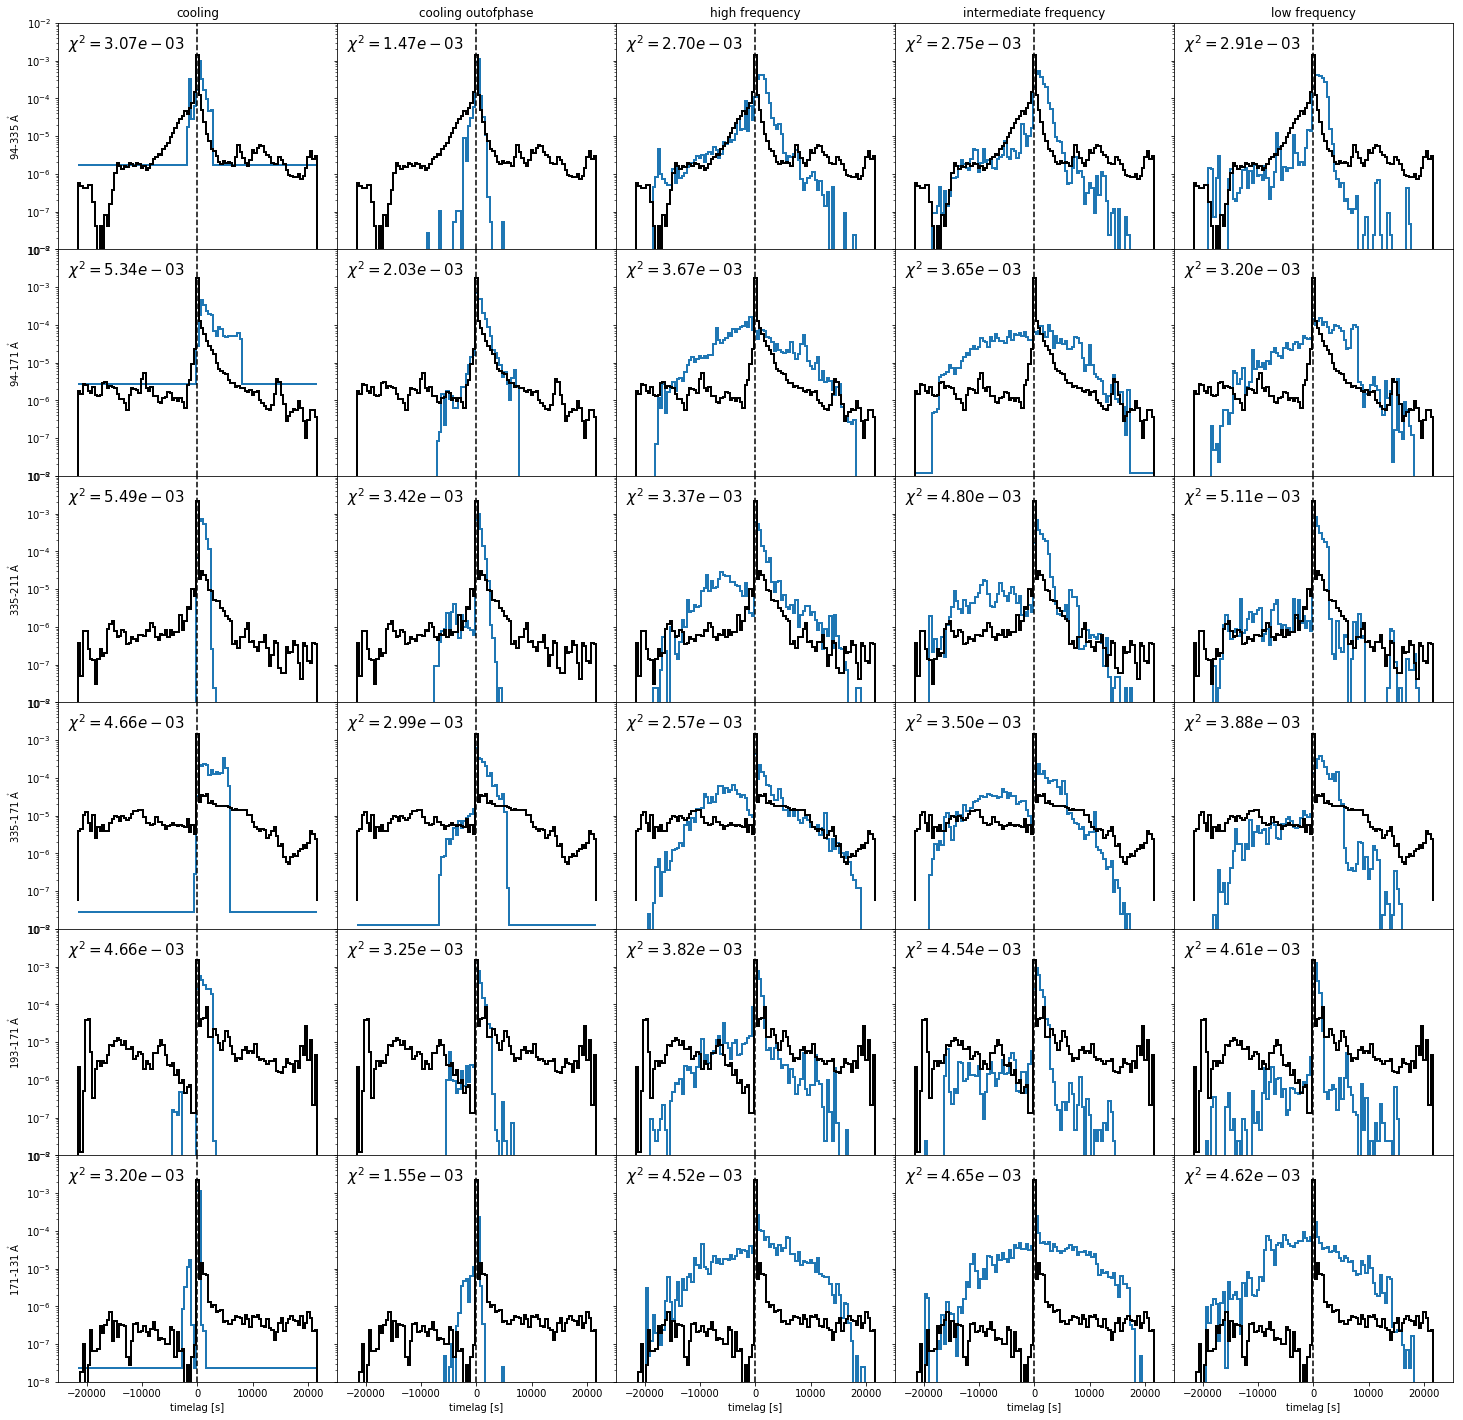

In [199]:
params = {'log':True,'bins':bins,'histtype':'step','lw':2,'normed':True,'cumulative':False}
fig,axes = plt.subplots(len(channel_pairs),5,figsize=(25,25),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
# tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
for i,p in enumerate(channel_pairs):
    for j,heating in enumerate([
                                'cooling',
                                'cooling_outofphase',
                                'high_frequency',
                                'intermediate_frequency',
                                'low_frequency'
                               ]):
        ax = axes[i,j]
        # Simulated timelag distributions
        tmp = timelag_maps['{}-{}'.format(*p)][heating]
        data = tmp.data.flatten()
        tmp = correlation_maps['{}-{}'.format(*p)][heating]
        data_cor = tmp.data.flatten()
        dist_sim = data[np.where(data_cor >= correlation_cutoff)]
        ax.hist(dist_sim, **params,color=f'C0',ls='-',)
        # Observed timelag distributions
        tmp = observed_timelag_maps['{}-{}'.format(*p)]
        data = tmp.data.flatten()
        tmp = observed_correlation_maps['{}-{}'.format(*p)]
        data_cor = tmp.data.flatten()
        dist_obs = data[np.where(data_cor >= correlation_cutoff)]
        ax.hist(dist_obs, **params,color=f'k',ls='-')
        # Test similarity
        chi2 = chi_squared_mod(dist_sim, dist_obs, bins, normed=params['normed'])
        # Labels and legends
        ax.text(-(6.5*u.hour).to(u.s).value, 2e-3, f'$\chi^2={chi2:.2e}$',fontsize=15)
        ax.axvline(x=0,ls='--',color='k')
        if j == 0:
            ax.set_ylabel(r'{}-{} $\mathrm{{\mathring{{A}}}}$'.format(*p))
        if i == 5:
            ax.set_xlabel(r'timelag [s]')
        if i == 0:
            ax.set_title(' '.join(heating.split('_')))
axes[0,0].set_xlim(-(7*u.hour).to(u.s).value, (7*u.hour).to(u.s).value);
axes[0,0].set_ylim(1e-8,1e-2);
#axes[0,0].set_ylim(1,2e5);